In [1]:
#Importing the libraries
import pandas as pd
import numpy as np

# Loading the data
input_file_path = '/Users/namanparuthi/Desktop/Amex/round 2/Amex Campus Challenge 2024 input.xlsx'
sheet1_name = 'batsman_scorecard'
sheet2_name = 'bowler_scorecard'
batsman_scorecard = pd.read_excel(input_file_path, sheet_name=sheet1_name)
bowler_scorecard = pd.read_excel(input_file_path, sheet_name=sheet2_name)

# Renaming columns for consistency
batsman_scorecard.rename(columns={'batsman_id': 'player_id'}, inplace=True)
bowler_scorecard.rename(columns={'bowler_id': 'player_id'}, inplace=True)

# Merging batsman and bowler data
all_rounder_data = pd.merge(batsman_scorecard, bowler_scorecard, on=['player_id', 'match id'], suffixes=('_bat', '_bowl'))

# Filtering players who played at least 2 matches
eligible_players = all_rounder_data.groupby('player_id').filter(lambda x: len(x) >= 2)

# Aggregating cumulative runs and wickets for each player
player_stats = eligible_players.groupby('player_id').agg(
    total_runs=('runs_bat', 'sum'),
    total_wickets=('wicket_count', 'sum')
).reset_index()

# Filtering players based on cumulative runs and wickets
qualified_players = player_stats[
    (player_stats['total_runs'] > 10) &
    (player_stats['total_wickets'] >= 1)
]['player_id']

# Filtering the data based on the qualified players
all_rounders = all_rounder_data[all_rounder_data['player_id'].isin(qualified_players)]
all_rounder_stats = all_rounders.groupby('player_id').agg(
    total_runs=pd.NamedAgg(column='runs_bat', aggfunc='sum'),
    total_runs_bowl=pd.NamedAgg(column='runs_bowl', aggfunc='sum'),
    total_wickets=pd.NamedAgg(column='wicket_count', aggfunc='sum'),
    innings=pd.NamedAgg(column='player_id', aggfunc='count'),
    hundreds=pd.NamedAgg(column='runs_bat', aggfunc=lambda x: (x >= 100).sum()),
    fifties=pd.NamedAgg(column='runs_bat', aggfunc=lambda x: ((x >= 50) & (x < 100)).sum()),
    four_wickets=pd.NamedAgg(column='wicket_count', aggfunc=lambda x: (x >= 4).sum()),
    batting_strike_rate=pd.NamedAgg(column='strike_rate', aggfunc='mean'),
    total_bowls_bowled=pd.NamedAgg(column='balls_bowled', aggfunc='sum'),
    economy=pd.NamedAgg(column='economy', aggfunc='mean')
).reset_index()

# Calculating batting average, bowling average and bowling strike rate
all_rounder_stats['batting_average'] = all_rounder_stats['total_runs'] / all_rounder_stats['innings']
all_rounder_stats['bowling_average'] = all_rounder_stats['total_runs_bowl'] / all_rounder_stats['total_wickets']
all_rounder_stats['strike_rate_bowl'] = (all_rounder_stats['total_bowls_bowled'] / all_rounder_stats['total_wickets'])

# Defining points assigning function
def assign_batting_sr_points(sr):
    if sr >= 150:
        return 50
    elif 100 <= sr < 150:
        return 40
    elif 80 <= sr < 100:
        return 30
    else:
        return 0

def assign_batting_avg_points(avg):
    if avg >= 50:
        return 30
    elif 40 <= avg < 50:
        return 20
    elif 30 <= avg < 40:
        return 10
    else:
        return 5

def assign_hundreds_points(hundreds):
    if hundreds >= 3:
        return 30
    elif hundreds == 2:
        return 20
    elif hundreds == 1:
        return 10
    else:
        return 0

def assign_fifties_points(fifties):
    if fifties >= 5:
        return 20
    elif 3 <= fifties <= 4:
        return 10
    elif 1 <= fifties <= 2:
        return 5
    else:
        return 0

def assign_bowling_sr_points(sr):
    if sr <= 15:
        return 30
    elif 15 < sr <= 19:
        return 20
    elif 19 < sr <= 24:
        return 10
    else:
        return 0

def assign_economy_points(economy):
    if economy <= 3:
        return 50
    elif 3 < economy <= 5:
        return 40
    elif 5 < economy <= 7:
        return 30
    else:
        return 0

def assign_bowling_avg_points(avg):
    if avg <= 20:
        return 30
    elif 20 < avg <= 30:
        return 20
    elif 30 < avg <= 40:
        return 10
    else:
        return 0

def assign_four_wickets_points(four_w):
    if four_w >= 4:
        return 30
    elif four_w == 2 or four_w == 3:
        return 20
    elif four_w == 1:
        return 10
    else:
        return 0

# Calculating points
all_rounder_stats['batting_sr_points'] = all_rounder_stats['batting_strike_rate'].apply(assign_batting_sr_points)
all_rounder_stats['batting_avg_points'] = all_rounder_stats['batting_average'].apply(assign_batting_avg_points)
all_rounder_stats['hundreds_points'] = all_rounder_stats['hundreds'].apply(assign_hundreds_points)
all_rounder_stats['fifties_points'] = all_rounder_stats['fifties'].apply(assign_fifties_points)
all_rounder_stats['economy_points'] = all_rounder_stats['economy'].apply(assign_economy_points)
all_rounder_stats['bowling_avg_points'] = all_rounder_stats['bowling_average'].apply(assign_bowling_avg_points)
all_rounder_stats['four_wickets_points'] = all_rounder_stats['four_wickets'].apply(assign_four_wickets_points)
all_rounder_stats['bowling_sr_points'] = all_rounder_stats['strike_rate_bowl'].apply(assign_bowling_sr_points)

# Calculating total points
all_rounder_stats['total_points'] = (
    all_rounder_stats['batting_sr_points'] +
    all_rounder_stats['batting_avg_points'] +
    all_rounder_stats['hundreds_points'] +
    all_rounder_stats['fifties_points'] +
    all_rounder_stats['economy_points'] +
    all_rounder_stats['bowling_avg_points'] +
    all_rounder_stats['four_wickets_points'] +
    all_rounder_stats['bowling_sr_points']
)

top_all_rounders_initial = all_rounder_stats.sort_values(by='total_points', ascending=False).head(10)

# Defining funtions for recency and consistency
def weighted_mean(scores):
    weights = np.arange(1, len(scores) + 1)
    return np.average(scores, weights=weights)

def consistency(scores):
    return np.std(scores)

# Sorting data for consistency calculations
all_rounders_sorted = all_rounders.sort_values(['player_id', 'match_dt_bat'])

# Calculating additional batting and bowling statistics with recency factor
batting_stats = all_rounders_sorted.groupby('player_id').agg(
    weighted_mean_runs=pd.NamedAgg(column='runs_bat', aggfunc=lambda x: weighted_mean(x)),
    consistency_runs=pd.NamedAgg(column='runs_bat', aggfunc=lambda x: consistency(x)),
).reset_index()

bowling_stats = all_rounders_sorted.groupby('player_id').agg(
    weighted_mean_wickets=pd.NamedAgg(column='wicket_count', aggfunc=lambda x: weighted_mean(x)),
    consistency_wickets=pd.NamedAgg(column='wicket_count', aggfunc=lambda x: consistency(x))
).reset_index()

# Merging additional stats into all_rounder_stats
all_rounder_stats = all_rounder_stats.merge(batting_stats, on='player_id')
all_rounder_stats = all_rounder_stats.merge(bowling_stats, on='player_id')

# Normalizing consistency
all_rounder_stats['normalized_consistency_runs'] = 1 / (1 + all_rounder_stats['consistency_runs'])
all_rounder_stats['normalized_consistency_wickets'] = 1 / (1 + all_rounder_stats['consistency_wickets'])

# Final score calculation
all_rounder_stats['final_score'] = (
    all_rounder_stats['total_points'] +
    all_rounder_stats['weighted_mean_runs'] +
    all_rounder_stats['normalized_consistency_runs'] * 100 +
    all_rounder_stats['weighted_mean_wickets'] +
    all_rounder_stats['normalized_consistency_wickets'] * 100
)

# Sorting by final score to get the top all-rounders
top_all_rounders = all_rounder_stats.sort_values('final_score', ascending=False)


In [2]:
top_all_rounders_initial

,player_id,total_runs,total_runs_bowl,total_wickets,innings,hundreds,fifties,four_wickets,batting_strike_rate,total_bowls_bowled,...,strike_rate_bowl,batting_sr_points,batting_avg_points,hundreds_points,fifties_points,economy_points,bowling_avg_points,four_wickets_points,bowling_sr_points,total_points
678,8127230,79,24,2,2,0,1,0,168.650000,18,...,9.000000,50,10,0,5,30,30,0,30,155
19,190574,56,55,5,3,0,0,0,156.546667,60,...,12.000000,50,5,0,0,30,30,0,30,145
260,3298427,585,399,23,23,0,3,1,117.646522,352,...,15.304348,40,5,0,10,30,30,10,20,145
634,7785448,24,37,3,2,0,0,0,170.240000,36,...,12.000000,50,5,0,0,30,30,0,30,145
285,3519011,802,1276,57,52,0,5,2,104.809231,1152,...,20.210526,40,5,0,20,30,20,20,10,145
661,8058903,101,20,2,4,0,0,0,101.610000,19,...,9.500000,40,5,0,0,40,30,0,30,145
694,8246440,114,121,16,8,0,0,1,105.867500,151,...,9.437500,40,5,0,0,30,30,10,30,145
647,7907661,44,140,9,7,0,0,1,133.810000,123,...,13.666667,40,5,0,0,30,30,10,30,145
452,5120674,284,273,15,13,0,1,1,144.817692,282,...,18.800000,40,5,0,5,30,30,10,20,140
644,7906968,352,295,17,14,0,1,1,120.853571,264,...,15.529412,40,5,0,5,30,30,10,20,140


In [3]:
top_all_rounders

,player_id,total_runs,total_runs_bowl,total_wickets,innings,hundreds,fifties,four_wickets,batting_strike_rate,total_bowls_bowled,...,four_wickets_points,bowling_sr_points,total_points,weighted_mean_runs,consistency_runs,weighted_mean_wickets,consistency_wickets,normalized_consistency_runs,normalized_consistency_wickets,final_score
678,8127230,79,24,2,2,0,1,0,168.650000,18,...,0,30,155,33.333333,18.500000,1.000000,0.000000,0.051282,1.000000,294.461538
635,7785497,15,33,5,2,0,0,0,86.310000,48,...,0,30,135,7.666667,0.500000,2.333333,0.500000,0.666667,0.666667,278.333333
437,4908532,57,37,3,3,0,0,0,98.150000,42,...,0,30,135,18.333333,5.887841,1.000000,0.000000,0.145183,1.000000,268.851672
367,4171985,18,29,1,2,0,0,0,107.145000,18,...,0,20,85,9.000000,0.000000,0.666667,0.500000,1.000000,0.666667,261.333333
124,2204950,50,66,4,3,0,0,0,136.666667,60,...,0,30,135,16.666667,0.942809,1.666667,0.942809,0.514719,0.514719,256.277058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3212278,51,281,5,10,0,0,0,69.796000,180,...,0,0,5,6.254545,7.091544,0.436364,0.670820,0.123586,0.598508,83.900327
597,7500324,29,111,2,6,0,0,0,56.250000,84,...,0,0,5,3.666667,4.810290,0.190476,0.745356,0.172108,0.572949,83.362890
684,8193310,34,150,4,6,0,0,0,57.010000,116,...,0,0,15,5.571429,6.749486,0.952381,1.105542,0.129041,0.474937,81.921610
345,4012203,128,587,13,21,0,0,0,75.102381,418,...,0,0,5,5.350649,8.836638,0.696970,0.652919,0.101661,0.604990,81.712709


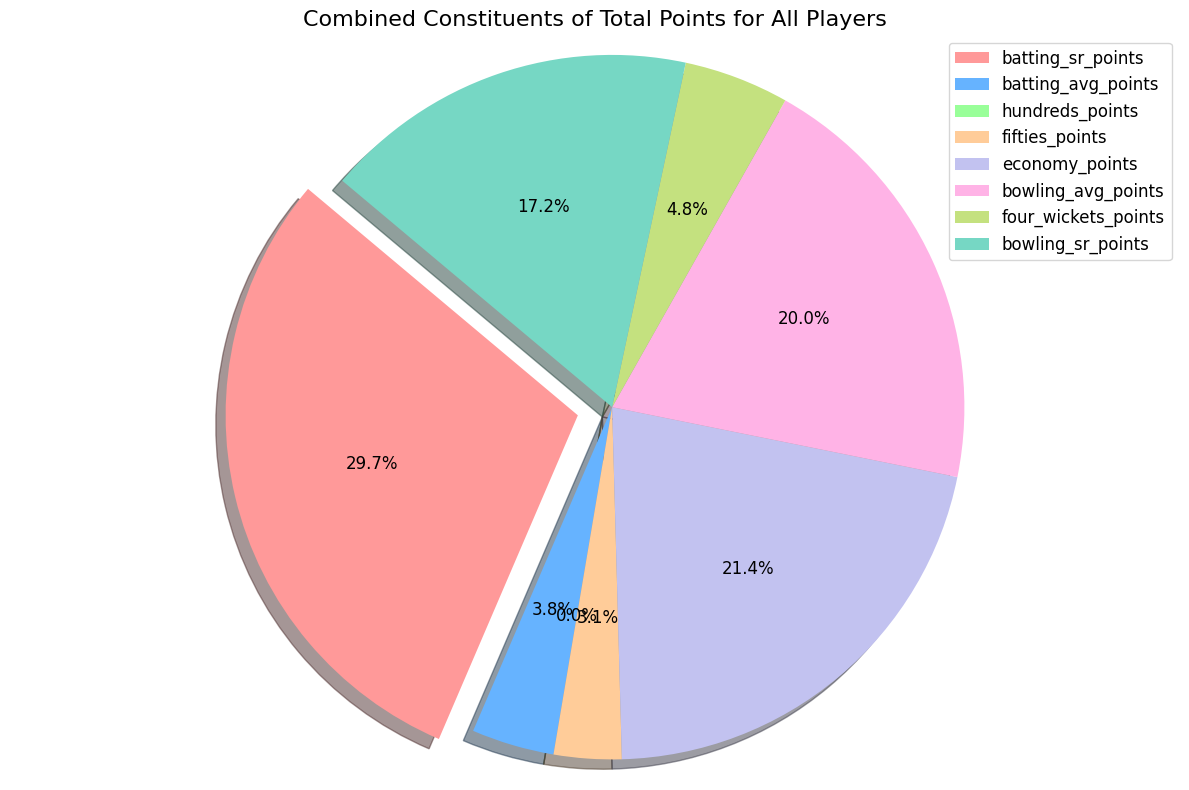

In [7]:
import matplotlib.pyplot as plt

# Define the metrics that contribute to total points
metrics = ['batting_sr_points', 'batting_avg_points', 'hundreds_points', 'fifties_points', 
           'economy_points', 'bowling_avg_points', 'four_wickets_points', 'bowling_sr_points']

# Aggregate the points for each metric across all players
aggregated_points = top_all_rounders_initial[metrics].sum()

# Define custom colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6', '#c4e17f','#76d7c4']

# Plotting the pie chart
plt.figure(figsize=(12, 8))
patches, texts, autotexts = plt.pie(aggregated_points, labels=None, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True, explode=(0.1, 0, 0, 0, 0, 0, 0, 0))

# Add a legend instead of labels
plt.legend(patches, aggregated_points.index, loc="best", fontsize='large')
plt.title('Combined Constituents of Total Points for All Players', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()

# Adjust text properties
for text in autotexts:
    text.set_fontsize(12)
    text.set_color('black')

plt.show()


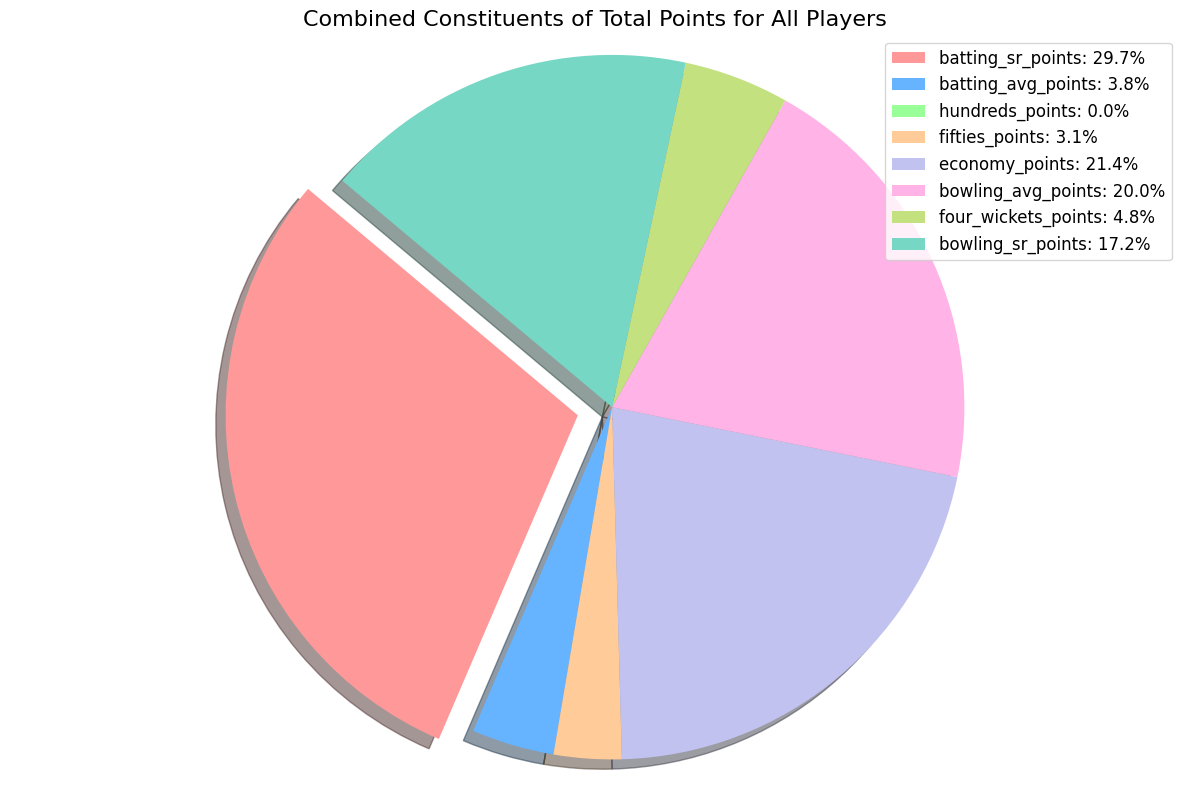

In [11]:
import matplotlib.pyplot as plt

# Define the metrics that contribute to total points
metrics = ['batting_sr_points', 'batting_avg_points', 'hundreds_points', 'fifties_points', 
           'economy_points', 'bowling_avg_points', 'four_wickets_points', 'bowling_sr_points']

# Aggregate the points for each metric across all players
aggregated_points = top_all_rounders_initial[metrics].sum()

# Define custom colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6', '#c4e17f','#76d7c4']

# Plotting the pie chart
plt.figure(figsize=(12, 8))
patches, texts = plt.pie(aggregated_points, labels=None, startangle=140, colors=colors, shadow=True, explode=(0.1, 0, 0, 0, 0, 0, 0, 0))

# Create legend labels with percentages
total = aggregated_points.sum()
legend_labels = [f'{metric}: {value/total*100:.1f}%' for metric, value in zip(aggregated_points.index, aggregated_points)]

# Add a legend instead of labels
plt.legend(patches, legend_labels, loc="best", fontsize='large')
plt.title('Combined Constituents of Total Points for All Players', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()

plt.show()
